In [1]:
# Libraries for interfacing with WFDB data
import wfdb
from wfdb import processing



#Classical libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.integrate import quad
from scipy.optimize import curve_fit
from numpy import trapz
from scipy.stats import norm



# importing detrending library
import obspy
from obspy.signal import detrend


## This function its used to store the ECG data inside the original files into a Pandas Dataframe

In [2]:
def import_ecg(path, files):
    
    '''
    Return ECG and RR_intervals dataframe.
    
    Inputs:
        path: path to the data's files
        files: files name without extentions
    
    outputs:
    return:
        ECG_sig: DataFrame with EGC signal for each file in each columns
        RR_intervals: DataFrame where in each columns are stored the interbeats intervals for each files
    '''


    # DataFrames to handle all signals (RAW ECG, RR intervals, Annotations, ...)
    ECG_sig=pd.DataFrame(columns=files)

    RR_intervals = pd.DataFrame(columns=files)



    # Read ECG data from files and store them in Pandas DataFrame
    # Save fields too, for further optional analysis
    signals_dfs=[]
    rr_dfs=[]

    for file in files:
        sig, fields =  wfdb.rdsamp(path + file, channels=[1]) # channel 1 maps to ECG data
        signals_dfs.append(pd.DataFrame({file: sig.T[0]}))

        xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
        xqrs.detect()
        rr=processing.calc_rr(xqrs.qrs_inds, fs=fields['fs'])

        #checking for problematic files
        #if np.sum(rr)==0:
        #    rr = processing.ann2rr(path+file, extension='ecg')
        rr_dfs.append(pd.DataFrame({file: rr}))

    ECG_sig=pd.concat(signals_dfs, ignore_index=True, axis=1)
    ECG_sig.columns=files

    RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
    RR_intervals.columns=files
    
    return ECG_sig, RR_intervals
    

## This function find problematic files and uses the annotation files to correct them
#### fixing this after loading the data inside the dataframe is a computationally faster way since we all already have the data stored inside the .hdf file and we need only to replace the corrupted column

In [3]:
def clean_df(RR_intervals, path_to_files):
    
    RR = RR_intervals.copy()
    files = list(RR.columns)
    
    #Extracting the problematc files name
    problematic_files = list(RR.columns[RR[files].sum() == 0])
    
    #Removing from the file list the problematic ones
    files = list(RR.columns[RR[files].sum() != 0])
    
    #Removing the columns which bare no value
    RR = RR.drop(problematic_files, axis=1)
    
    #Adding the new columns to the dataframe and the files name to the list
    for file in problematic_files:
        rr = processing.ann2rr(path_to_files+file, extension='ecg')
        RR = pd.concat([RR, pd.Series(rr, name=file)], axis=1)

    new_files = files + problematic_files
    
    return RR, new_files
    

## Function to compute the detrended data and then the increments from the comulative function

In [4]:
def increments(B_df, s_list, polydegree=3):
    '''
    Inputs:
        B: Dataframe with the columns to be detrended
        s_list: List of value of s to be used to detrend B
        polydegree: Polynomial's degree used to detred the data
    
    Output:
        return : List of array containing the detrended data increments for each column of B
    
    '''
    fnames = list(B_df.columns) #columns name list
    list_DB=[]
    
    for s in s_list:
        
        Delta_B_s=[] #empy list to store the increamets for a specific s regardless of the file from which the data come from

        
        for B in B_df[fnames].values.T:
            
            B = B[~np.isnan(B)] #removing all nan values from B     
            nmax_seg=int(np.floor(B.size/(2*s))) #maximum number of possible segments with increment s over B
            
            
            if nmax_seg!= 0: #avoid useless computing power
                
                for indx in range(nmax_seg):
                    detrend.polynomial(B[indx*2*s: (indx+1)*2*s], order=polydegree, plot=False) # for each sliding segment, detrend

                # the whole B but now detrended
                #detrended=B[0:2*s*nmax_seg].copy() #only those that are possible to detrend (have at least the 2s space/segment)
                detrended=B[0:2*s*nmax_seg]
                Delta_s_B_file=np.array([detrended[i+s]-detrended[i] for i in range(2*s*nmax_seg) if i+s< len(detrended)])
                Delta_B_s.append(Delta_s_B_file/np.std(Delta_s_B_file)) #since the std of very patient i svery different from each other we need to normalize the increments and join them togheter
        list_DB.append(np.concatenate(Delta_B_s))
    
    return list_DB


## Defining gaussian and Castaing's functions to fit the data

In [5]:
def gaus(x, mu, sigma, A):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2 / (2*sigma**2))

In [6]:
def castaing_integral(x, lambd, sigma_0):
    def little_cast(sigma, lambd, x, sigma_0):
        return 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma/sigma_0)**2/lambd**2) / 2)
    result = quad(little_cast, 0, np.inf, args=(lambd, x, sigma_0))
    return result[0]

# scipy_integrate accepts only scalar functions, we can vectorize it this way
Castaing_integral = np.vectorize(castaing_integral)

## Setting the path to the data and the file's name in order to access them

In [7]:
path='physionet.org/files/fantasia/1.0.0/' # relative path to data files
files= np.loadtxt(path+'RECORDS', dtype='str') # name of all files (no extensions as required by wfdb functions)

## This cell is meant to run only when first importing the data

In [8]:
'''
ECG_sig, RR_intervals_originals = import_ecg(path, files)
ECG_sig.to_hdf('ECG_sig.hdf', key='ECG_sig')
RR_intervals_originals.to_hdf('RR_intervals_originals.hdf', key='RR_intervals')
'''

"\nECG_sig, RR_intervals_originals = import_ecg(path, files)\nECG_sig.to_hdf('ECG_sig.hdf', key='ECG_sig')\nRR_intervals_originals.to_hdf('RR_intervals_originals.hdf', key='RR_intervals')\n"

## Plot of ECG signal

In [8]:
ECG=pd.read_hdf('ECG_sig.hdf')

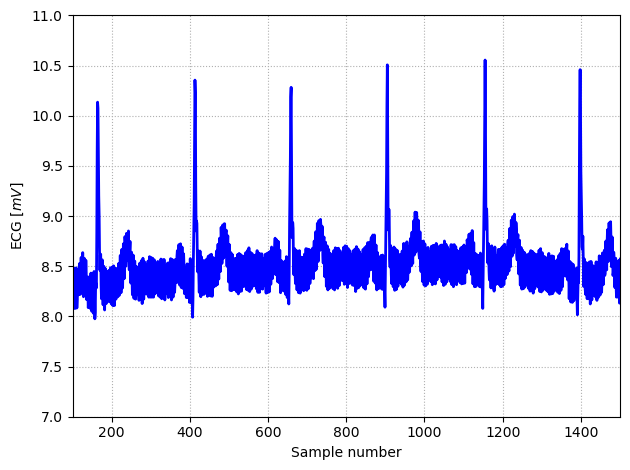

In [51]:

plt.plot(ECG[files[0]], linewidth=2, color='blue', )

plt.xlim(100, 1500)
plt.ylim(7, 11)
plt.xlabel(r'Sample number')
plt.ylabel(r'ECG $[mV]$')
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('ECG6.png')
plt.show()


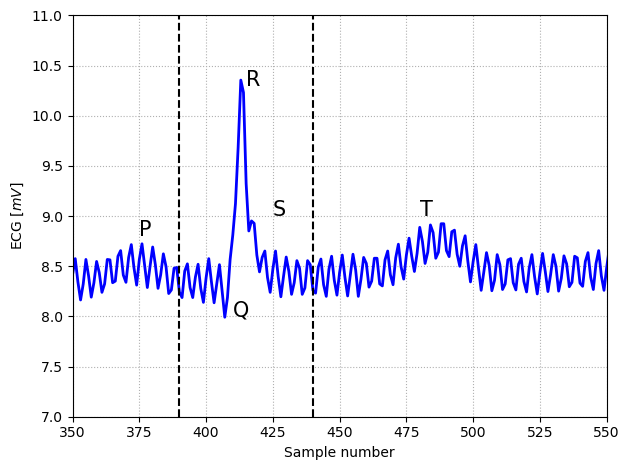

In [50]:
plt.plot(ECG[files[0]], linewidth=2, color='blue')

plt.xlim(350, 550)
plt.ylim(7, 11)
plt.xlabel(r'Sample number')
plt.ylabel(r'ECG $[mV]$')
plt.grid(linestyle='dotted')

plt.vlines(390, 7, 11, linestyle='--', color='black')
plt.vlines(440, 7, 11, linestyle='--', color='black')
plt.text(375, 8.8, r'P', size=15 )
plt.text(410, 8, r'Q', size=15 )
plt.text(415, 10.3, r'R', size=15 )
plt.text(425, 9, r'S', size=15 )
plt.text(480, 9, r'T', size=15 )



plt.tight_layout()
plt.savefig('ECG1.png')
plt.show()

## Loading the data inside a Dataframe for easier manipulation

In [9]:
RR_intervals_original=pd.read_hdf('RR_intervals.hdf')
#RR_intervals.describe()

## Clensing the dataframe from the Nan columns

In [10]:
RR_intervals, files = clean_df(RR_intervals_original, path)

## We clean the data redefining the ones that exede the interval (mean - f x std, mean+f x std)

In [11]:
factor=3

for file in files:
    mean = RR_intervals[file].mean()
    std  = RR_intervals[file].std()

    RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean


/tmp/ipykernel_11126/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean
/tmp/ipykernel_11126/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean
/tmp/ipykernel_11126/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

# Constructing the cumulative functions from the beats intervals

In [12]:
B=pd.DataFrame(np.cumsum(RR_intervals, axis=0))
B.describe() # columns names are correct

,f1o01,f1o02,f1o03,f1o04,f1o05,f1o06,f1o07,f1o08,f1o09,f1o10,...,f2y06,f2y07,f2o02,f2o05,f2o10,f2y01,f2y05,f2y08,f2y09,f2y10
count,7.171000e+03,6.822000e+03,7.228000e+03,6.243000e+03,5.734000e+03,6.230000e+03,7.149000e+03,8.494000e+03,4.925000e+03,8.240000e+03,...,6.850000e+03,6.505000e+03,6.372000e+03,8.469000e+03,8.441000e+03,8.106000e+03,9.248000e+03,7.378000e+03,8.811000e+03,7.114000e+03
mean,9.027390e+05,8.976991e+05,8.970521e+05,9.090362e+05,7.712857e+05,9.140689e+05,8.937041e+05,8.952436e+05,8.989169e+05,9.008093e+05,...,8.597880e+05,8.750737e+05,8.810655e+05,8.639431e+05,8.391006e+05,8.844176e+05,8.924785e+05,9.145971e+05,8.952708e+05,8.768395e+05
std,5.271829e+05,5.259815e+05,5.247960e+05,5.247688e+05,4.512111e+05,5.257675e+05,5.238034e+05,5.263810e+05,5.279110e+05,5.261720e+05,...,5.059033e+05,5.057830e+05,5.116299e+05,5.109759e+05,4.949159e+05,5.106569e+05,5.145612e+05,5.289099e+05,5.267888e+05,5.182389e+05
min,2.490000e+02,2.410000e+02,2.508641e+02,3.090000e+02,2.530000e+02,3.120000e+02,2.480000e+02,1.860000e+02,3.680000e+02,2.270000e+02,...,2.350000e+02,2.440000e+02,2.758035e+02,2.078463e+02,2.006125e+02,2.181794e+02,1.897944e+02,2.452850e+02,1.000000e+02,2.480000e+02
25%,4.440005e+05,4.396348e+05,4.400402e+05,4.534237e+05,3.786013e+05,4.592643e+05,4.386642e+05,4.346900e+05,4.445709e+05,4.419965e+05,...,4.216348e+05,4.415792e+05,4.346383e+05,4.178128e+05,4.050939e+05,4.414438e+05,4.443054e+05,4.543177e+05,4.358860e+05,4.241432e+05
50%,8.988845e+05,8.942683e+05,8.916156e+05,9.098094e+05,7.660805e+05,9.147192e+05,8.861597e+05,8.928344e+05,8.871863e+05,8.965930e+05,...,8.476985e+05,8.741493e+05,8.834722e+05,8.539291e+05,8.390129e+05,8.867278e+05,8.949549e+05,9.199256e+05,8.869855e+05,8.699987e+05
75%,1.360582e+06,1.355261e+06,1.350185e+06,1.366886e+06,1.161520e+06,1.370577e+06,1.347438e+06,1.351584e+06,1.354774e+06,1.357799e+06,...,1.296569e+06,1.311033e+06,1.327021e+06,1.305285e+06,1.271151e+06,1.324048e+06,1.341569e+06,1.373222e+06,1.354647e+06,1.325353e+06
max,1.814486e+06,1.811258e+06,1.813989e+06,1.813740e+06,1.559695e+06,1.821476e+06,1.812119e+06,1.806026e+06,1.825462e+06,1.814685e+06,...,1.755131e+06,1.754705e+06,1.758471e+06,1.762846e+06,1.693635e+06,1.770612e+06,1.758908e+06,1.818147e+06,1.805731e+06,1.785666e+06


## Defining the values for s and computing the increments

In [13]:
S=[2**i for i in range(3, 12)]
list_Delta_B= increments(B, S, polydegree=3 )

## Plotting the fitted increments using a gaussian fit

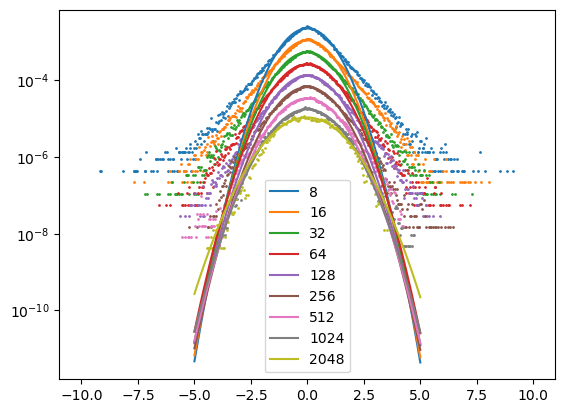

In [14]:
for i, DBs in enumerate(list_Delta_B):
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
        
    popt, pcov = curve_fit(gaus , bin_cen, counts/(S[i]*len(DBs)), p0=[1,1,1])
    
    x = np.linspace(-5, 5, 100)
    plt.plot(x, gaus(x, *popt), label=str(S[i]))
    
    plt.scatter(bin_cen, counts/(S[i]*len(DBs)), s=1)
    plt.yscale('log')
plt.legend()
plt.show()

## Plotting the fitted data using the Castaing equation

8 (lamda, sigma0) 0.416486070945585 0.8575050604845719
16 (lamda, sigma0) 0.41848824930378387 0.8781099992921306
32 (lamda, sigma0) 0.37524063174460975 0.9008675207233267
64 (lamda, sigma0) 0.3193405856940156 0.9230015246123042
128 (lamda, sigma0) 0.3355537998156658 0.9237162249323342
256 (lamda, sigma0) 0.32927395634505846 0.9338299117878667
512 (lamda, sigma0) 0.26439144257021413 0.953583733762965
1024 (lamda, sigma0) 0.2371453540592915 0.985364783983992
2048 (lamda, sigma0) 0.003009608395037978 1.069686980355244


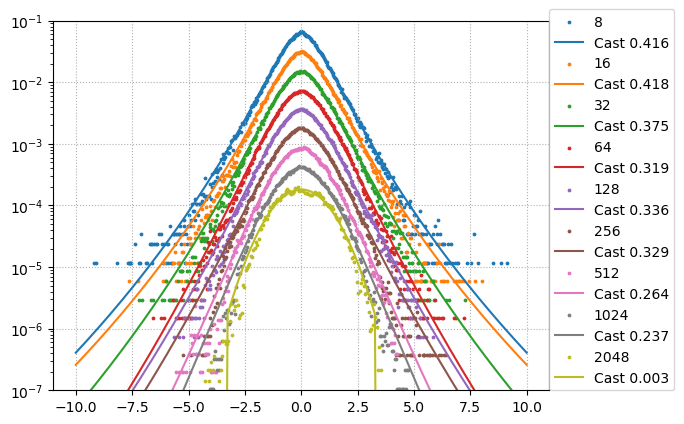

In [15]:
for i,DBs in enumerate(list_Delta_B):
    
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
    counts=counts/np.trapz(counts, bin_cen)

    plt.scatter(bin_cen, counts/S[i], s=3, label=str(S[i]))
    
    popt, pcov = curve_fit(Castaing_integral, bin_cen, counts, p0=[np.sqrt(0.16), 1])
    
    
    
    x=np.linspace(-10, 10, 200)
    plt.plot(x, Castaing_integral(x, *popt)/S[i], label='Cast {:.3f}'.format(*popt))
    print(S[i],'(lamda, sigma0)', *popt)


plt.legend(loc=(1,0))
#plt.xlim(-2,2)
plt.yscale('log')
#plt.ylim(10e-6, 10e1)
plt.grid(linestyle='dotted')
#plt.xlim(-1,1)
plt.ylim(1e-7, 1e-1)
plt.show()

## Generating the collapse plot from all data 

In [16]:
complete_dataset=np.concatenate(list_Delta_B)

(1498,) (1498,)
Chi squared 0.0003795949465523501
Chi squared g 0.0017707765439212624


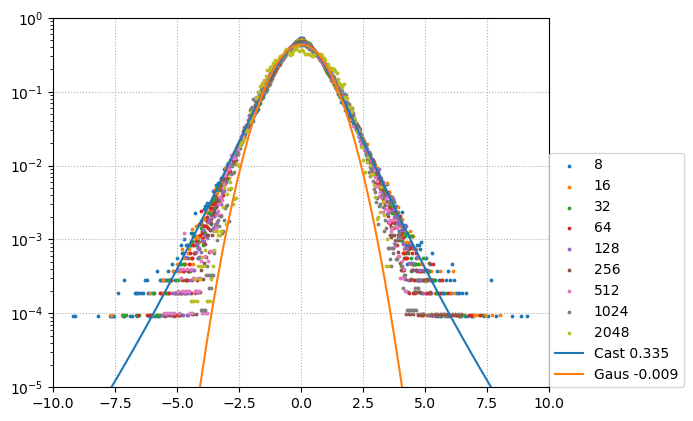

In [17]:


for i,DBs in enumerate(list_Delta_B):
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
    #print('Area before norm',np.trapz(counts, bin_cen))
    #plt.scatter(bin_cen, counts, s=3)

    #print('SONO UGUALI?',len(d), np.sum(counts))
    counts=counts/np.trapz(counts, bin_cen)

    #print('Area after norm',np.trapz(counts, bin_cen))
    plt.scatter(bin_cen, counts, s=3, label=str(S[i]))

    mu, std=norm.fit(counts, fscale=1) # to imporove to properly fit data
    #print(std)
    #p = norm.pdf(x, mu, std)

    #
    #print(S[i],'lambda=', *popt)

    #for i in range(1,20):
    #plt.plot(x, Castaing_integral(x, 0.3), label='Cast '+str(0.3))

x=np.linspace(-10, 10, 200)
counts_all, edges_all=np.histogram(complete_dataset, bins=int(np.sqrt(complete_dataset.size)), range=(-10, 10))

bin_cen_all=(edges_all[1:]+edges_all[:-1])/2
counts_all=counts_all/np.trapz(counts_all, bin_cen_all)

popt, pcov = curve_fit(Castaing_integral, bin_cen_all, counts_all, p0=[np.sqrt(0.16), 1])
plt.plot(x, Castaing_integral(x, *popt), label='Cast {:.3f}'.format(*popt))

popt_g, pcov_g = curve_fit(gaus, bin_cen_all, counts_all, p0=[np.sqrt(0.16), 1, 1])
plt.plot(x, gaus(x, *popt_g), label='Gaus {:.3f}'.format(*popt_g))

print(counts_all.shape, Castaing_integral(bin_cen_all, *popt).shape)
#print('Chi all',chisquare(f_obs=counts_all, f_exp=Castaing_integral(bin_cen_all, *popt), ddof=2))
chi_2=np.sum((counts_all[counts_all!=0]-Castaing_integral(bin_cen_all[counts_all!=0], *popt))**2/(counts_all[counts_all!=0]))/(counts_all[counts_all!=0].shape[0]-2)
print('Chi squared', chi_2)

chi_2_g=np.sum((counts_all[counts_all!=0]-gaus(bin_cen_all[counts_all!=0], *popt_g))**2/(counts_all[counts_all!=0]))/(counts_all[counts_all!=0].shape[0]-2)
print('Chi squared g', chi_2_g)

plt.legend(loc=(1,0))
#plt.xlim(-2,2)
plt.yscale('log')
#plt.ylim(10e-6, 10e1)
plt.grid(linestyle='dotted')
#plt.xlim(-1,1)
plt.xlim(-10,10)
plt.ylim(1e-5, 1e0)
plt.show()

